# Laplaceova matrica povezanosti grafa

## Ante Vuković

In [1]:
import networkx as nx
import numpy as np
from scipy.linalg import eigh
from scipy.special import comb

Networkx sadrži metodu node_disjoint_paths(G, s, t) koja računa vršno disjunktne putove između dva vrha u grafu za proslijeđen graf G te vrhove s i t. Problem možemo reducirati na problem maksimalnog toka te ga tim putem i riješiti. Ukoliko ne odredimo drugu metodu, node_disjoint_paths koristi Edmonds-Karp algoritam. U njemu se za pronalazak maksimalnog toka koristi BFS. Za računanje broja vršno disjunktnih putova, svi će kapaciteti biti postavljeni na 1.
Ukupna vremenska složenost Edmonds-Karp algoritma je jednaka umnošku broja iteracija $O(VE)$ i složenosti jednog BFS-a $O(E)$. Dakle, složenost algoritma iznosi $O(VE^2)$.

Pogledajmo primjenu metode za vrhove 0 i 5 u potpunom multipartitnom grafu:

3

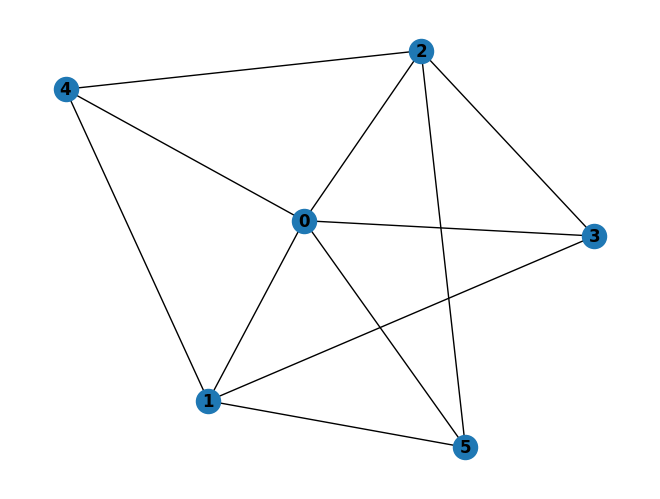

In [3]:
G = nx.complete_multipartite_graph(1, 2, 3)
nx.draw(G, with_labels=True, font_weight='bold')
len(list(nx.node_disjoint_paths(G, 0, 5)))

Za graf $G$ sa skupom vrhova {1,2,...,n} $D$ je dijagonalna matrica koja na glavnoj dijagonali sadrži stupnjeve vrhova grafa $G$, dok je $A$ matrica susjedstva koja na poziciji $(i,j)$ sadrži broj bridova koji spajaju vrhove $i$ i $j$. Laplaceoca se matrica za takav graf računa kao $L=D-A$.

Laplaceova matrica povezanosti $LC$ grafa $G$ definirana je s $LC = D - P$, gdje je $P$ matrica koja na $(i,j)$-toj poziciji sadrži broj vršno disjunktnih putova koji spajaju vrhove $i$ i $j$ u $G$, pri čemu su joj elementi glavne dijagonale jednaki nuli. $D$ je dijagonalna matrica koja na $(i,i)$-toj poziciji sadrži ukupan broj vršno disjunktnih putova kojima je jedan kraj vrh $i$. 

Matrica $P$ je simetrična pošto je graf neusmjeren te je zbog toga broj vršno disjunktnih putova između vrhova $i$ i $j$ jednak broju vršno disjunktnih putova između vrhova $j$ i $i$. Zato je simetrična i matrica $LC$.

$LC$ je pozitivno semidefinitna jer su joj sve svojstvene vrijednosti $\lambda_i \ge 0$.

$LC$ je dijagonalizabilna pošto je realna i simetrična.

In [2]:
def LapConMatrix(G: nx.Graph):
    nodes = list(G.nodes())
    n = len(nodes)
    P = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i+1, n):
            u, v = nodes[i], nodes[j]
            num_paths = len(list(nx.node_disjoint_paths(G, u, v)))
            P[i, j] = num_paths
            P[j, i] = num_paths
    sums = np.sum(P, axis=1)
    D = np.diag(sums)
    LC = D - P
    return LC, P
    

U matematičkom teoriji grafova, Brouwerova pretpostavka je pretpostavka koju je postavio Andries Brouwer o gornjim granicama za međuzbrojeve svosjtvenih vrijednosti Laplaceove matrice grafa, izraženim u odnosu na broj bridova tog grafa.

Pretpostavka glasi:
Ako je G jednostavan neusmjereni graf, a L(G) njegova Laplaceova matrica, tada njegove svosjtvene vrijednosti
$\Lambda_n(L(G))$ ≤ $\Lambda_{\textrm{n-1}}(L(G))$ ≤ ... ≤ $\Lambda_1(L(G))$ zadovoljavaju

$$
\sum\limits_{i=1}^t (\Lambda_i(L(G))) \le m(G) + {t+1 \choose 2}, t = 1, ..., n
$$

gdje je m(G) broj bridova u G.

Iz modula scipy.special uvozimo comb, što je funkcija povrh ili binomni koeficijent definirana kao ${n \choose k} = \frac{n!}{k!(n-k)!}$

Iz scipy.linalg uvozimo funkciju eigh koja nam za danu kompleksnu hermitsku ili realnu simetričnu matricu vraća njene svojstvene vrijednosti i vektore. Izvorni kod te funkcije možemo pronaći na poveznici https://github.com/scipy/scipy/blob/v1.15.3/scipy/linalg/_decomp.py#L0-L1. Funkcija koristi LAPACK drivere te vremenska složenost algoritma za matricu dimenzija nxn ovisi o izboru drivera. Ukoliko ne odaberemo driver, zadana je vrijednost evr. Također, driveri se prefiksiraju sa sy za realnu ili he za kompleksnu matricu.

Sa driverom evr, scipy.linalg.eigh računa MRRR(Multiple Relatively Robust Representations) algoritmom. Umjesto da izračuna sve svojstvene vrijednosti i vektore iz jedne reprezentacije matrice, MRRR koristi više numerički stabilnih reprezentacija, svaku prilagođenu da precizno i stabilno izračuna ograničeni podskup spektra.

Simetričnu matricu A reducira se na tridijagonalnu matricu T (u tridijagonalnoj se matrici nenul elementi nalaze na glavnoj dijagonali te na dijagonalama neposredno iznad i ispod glavne, a svi elementi van te tri dijagonale su nule).
$$A = QTQ^T$$

Tridiagonalna matrica $T$ se prikazuje kao početna relativno robusna reprezentacija (RRR) — oblik $LDL^T$ gdje je $L$ donjetrokutasta, a $D$ dijagonalna matrica

Koristi se metoda bisekcije za pronalaženje korijena karakterističnog polinoma(svojstvenih vrijednosti) matrice pomoću Sturmovih nizova.

Spektar se analizom razlike između susjednih svojstvenih vrijednosti rekurzivno dijeli kako bi se identificirali skupovi bliskih (klasteriranih) i udaljenih vrijednosti.

Za svaki klaster svojstvenih vrijednosti algoritam generira novu RRR koja je numerički stabilna za taj dio spektra. Time se izbjegavaju problemi zbog loše uvjetovanosti.

Vlastiti se vektori određuju iz tih reprezentacija koristeći metodu inverzne iteracije.

MRRR ima vremensku složenost $O(kn^2)$, gdje je $k$ broj svojstvenih vrijednosti koje računamo.

Zbog tih kalkulacija, numeričke vrijednosti u svojstvenim vrijednostima i vektorima zaokružujemo na 4 decimale. Bez zaokruživanja, umjesto sedam vrijednosti 8.0, možemo imati jednu vrijednost 7.999999999999999, pet vrijednosti 8.0 i jednu vrijednost 8.000000000000009

In [ ]:
#Klasična

def brouwer_c(evals, m):
    sumsv = 0
    for i in range(len(evals)):
        sumsv += evals[i]
        #i kreće od 0, a ne 1 pa pišemo i+2.
        if sumsv > (m + comb(i+2, 2)):
            return False
    return True

Klasična Brouwerova hipoteza neće nužno vrijediti za Laplaceovu matricu povezanosti kao što vrijedi za klasičnu Laplaceovu matricu. Kako bi radila, možemo promijeniti m tako da, umjesto broja bridova grafa, predstavlja ukupan zbroj vršno disjunktnih putova između vrhova u grafu, koji je jednak zbroju svih vrijednosti iz gornjeg trokuta matrice P. Također, možemo promijeniti binomni koeficijent iz ${t+1 \choose 2}$ u ${t+3 \choose 4}$.

In [ ]:
#Modificirana

def brouwer(evals, P):
    sumsv = 0
    m = np.sum(np.triu(P, 1))
    p_max = np.max(P)
    for i in range(len(evals)):
        sumsv += evals[i]
        #i kreće od 0, a ne 1 pa pišemo i+4.
        if sumsv > (m + comb(i+4, 4)):
            return False
    return True

In [5]:
def sve1(G: nx.Graph):
    #m = G.number_of_edges()
    LC, P = LapConMatrix(G)
    evals, evecs = eigh(LC)
    #U simetričnoj su matrici sv. vr. uvijek realne pa možemo koristiti eigh
    print("LC matrica: ")
    print(LC)

    evl = np.round(evals[::-1], 4)
    evc = np.round(evecs, 4)
    evl.sort()
    dict={}
    for eval in evl:
        if eval in dict:
            dict[eval]+=1
        else:
            dict[eval]=1
    print("Svojstvene vrijednosti: ")
    for k, v in dict.items():
       print(k, v)
    print("Svojstveni vektori: ")
    print(evc)
    nx.draw(G, with_labels=True, font_weight='bold')
    if(brouwer(evl, P)):
        print("Modificirana hipoteza vrijedi za dani graf.")
    else:
        print("Modificirana hipoteza ne vrijedi za dani graf.")

In [6]:
def sve(G: nx.Graph):
    LC, P = LapConMatrix(G)
    evals, evecs = eigh(LC)

    evl = np.round(evals[::-1], 4)
    evc = np.round(evecs, 4)
    evl.sort()
    dict={}
    for eval in evl:
        if eval in dict:
            dict[eval]+=1
        else:
            dict[eval]=1
    return(brouwer(evl, P))

In [7]:
def sve1_c(G: nx.Graph):
    m = G.number_of_edges()
    LC, P = LapConMatrix(G)
    evals, evecs = eigh(LC)

    evl = np.round(evals[::-1], 4)
    evc = np.round(evecs, 4)
    evl.sort()
    if(brouwer_c(evl, m)):
        print("Klasična hipoteza vrijedi za dani graf.")
    else:
        print("Klasična hipoteza ne vrijedi za dani graf.")

In [8]:
def sve_c(G: nx.Graph):
    m = G.number_of_edges()
    LC, P = LapConMatrix(G)
    evals, evecs = eigh(LC)

    evl = np.round(evals[::-1], 4)
    evc = np.round(evecs, 4)
    evl.sort()
    return(brouwer_c(evl, m))

## Savršeno balansirano stablo

Savršeno balansirano r-arno stablo je tip stabla u kojemu su svi listovi na jednakoj dubini i svaki čvor(osim listova) ima točno r djece. Generira ga se funkcijom nx.balanced_tree(r, h), gdje je h visina stabla.

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 10 parova vrijednosti.
LC matrica: 
[[20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -

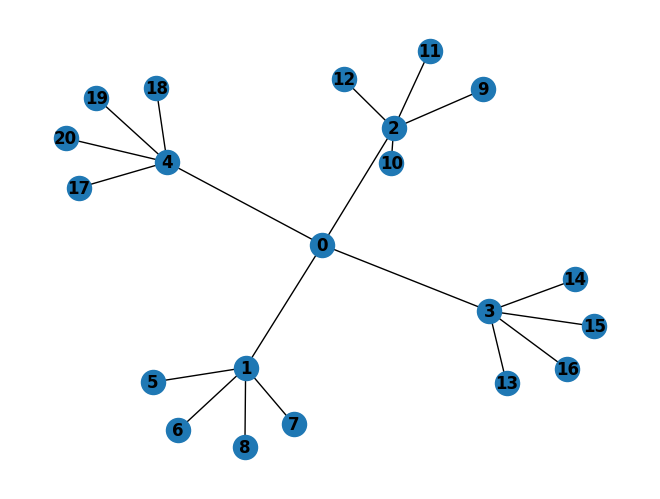

In [114]:
f1=0
f2=0
for r in range(1, 6):
    for h in range(1, 4):
        if(not sve(nx.balanced_tree(r, h))):
            f1+=1
        if(not sve_c(nx.balanced_tree(r, h))):
            f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} parova vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} parova vrijednosti.")

G=nx.balanced_tree(4,2)
sve1(G)
sve1_c(G)

## Utegasti graf

Utegasti se graf sastoji od dva potpuna grafa od m1 čvorova povezanih putom od m2 čvorova. Generira ga se funkcijom nx.barbell_graph(m1, m2.)

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 39 parova vrijednosti.
LC matrica: 
[[26 -4 -4 -4 -4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-4 26 -4 -4 -4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-4 -4 26 -4 -4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-4 -4 -4 26 -4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-4 -4 -4 -4 26 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 26 -4 -4 -4 -4]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -4 26 -4 -4 -4]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -4 -4 26 -4 -4]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -4 -4 -4 26 -4]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -4 -4 -4 -4 26]]
Svojstvene vrijednosti: 
0.0 1
15.0 6
30.0 8
Svojstveni vektori: 
[[-0.2582  0.      0.     -0.3651  0.      0.      0.      0.      0.
   0.      0.      

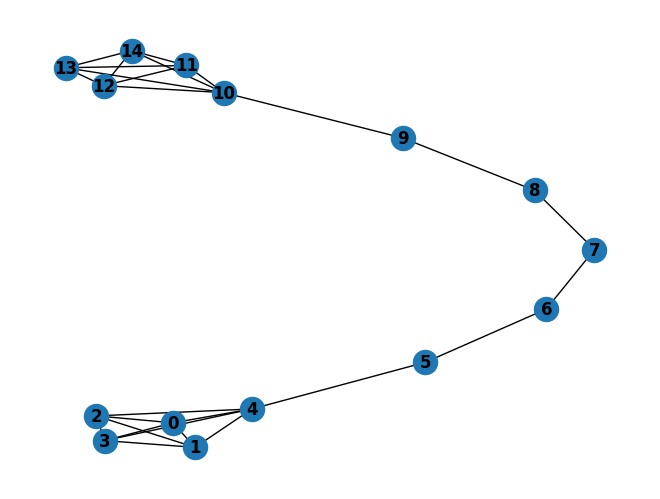

In [121]:
f1=0
f2=0
for m1 in range(2, 15):
    for m2 in range(2, 5):
        if(not sve(nx.barbell_graph(m1, m2))):
            f1+=1
        if(not sve_c(nx.barbell_graph(m1, m2))):
            f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} parova vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} parova vrijednosti.")

G = nx.barbell_graph(5, 5)
sve1(G)
sve1_c(G)

## Binomno stablo

Binomno stablo nultog reda je samo jedan čvor. Binomno stablo k-tog reda se rekurzivno definira spajanjem dvaju binomnih stabala (k-1)-og reda tako da korijen jednog stabla postaje lijevo dijete korijena drugog stabla. Generira ga se funkcijom nx.binomial_tree(k).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 4 vrijednosti.
LC matrica: 
[[15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15]]
Svojstvene vrijednosti: 
-0.0 1
16.0 15
Svojstveni vektori: 
[[-0.2

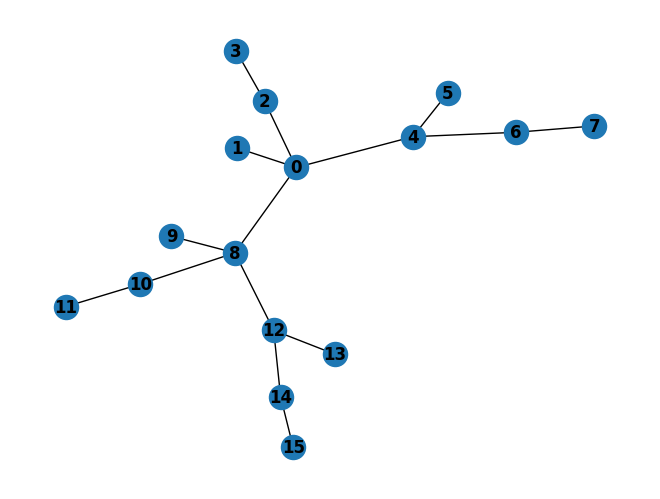

In [125]:
f1=0
f2=0
for k in range(3, 7):
    if(not sve(nx.binomial_tree(k))):
        f1+=1
    if(not sve_c(nx.binomial_tree(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.binomial_tree(4)
sve1(G)
sve1_c(G)

## Potpuni graf

Potpuni je graf tip grafa u kojem su svi čvorovi povezani bridovima. Generira ga se funkcijom nx.complete_graph(n), gdje je n broj čvorova.

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 22 vrijednosti.
LC matrica: 
[[81 -9 -9 -9 -9 -9 -9 -9 -9 -9]
 [-9 81 -9 -9 -9 -9 -9 -9 -9 -9]
 [-9 -9 81 -9 -9 -9 -9 -9 -9 -9]
 [-9 -9 -9 81 -9 -9 -9 -9 -9 -9]
 [-9 -9 -9 -9 81 -9 -9 -9 -9 -9]
 [-9 -9 -9 -9 -9 81 -9 -9 -9 -9]
 [-9 -9 -9 -9 -9 -9 81 -9 -9 -9]
 [-9 -9 -9 -9 -9 -9 -9 81 -9 -9]
 [-9 -9 -9 -9 -9 -9 -9 -9 81 -9]
 [-9 -9 -9 -9 -9 -9 -9 -9 -9 81]]
Svojstvene vrijednosti: 
0.0 1
90.0 9
Svojstveni vektori: 
[[-0.3162  0.9487  0.      0.      0.      0.      0.      0.      0.
   0.    ]
 [-0.3162 -0.1054  0.9285  0.0182  0.0224 -0.1304 -0.0778  0.0015  0.0474
  -0.0259]
 [-0.3162 -0.1054 -0.1393  0.8392 -0.3593 -0.1594  0.0854 -0.0016 -0.052
   0.0284]
 [-0.3162 -0.1054 -0.1393 -0.3034  0.1076 -0.6154  0.5113 -0.0099 -0.3111
   0.1699]
 [-0.3162 -0.1054  0.0464 -0.1049 -0.1289  0.7499  0.4476 -0.0086 -0.2723
   0.1487]
 [-0.3162 -0.1054 -0.1393 -0.3034 -0.4233 -0.028  -0.4345 -0.0118 -0.3728

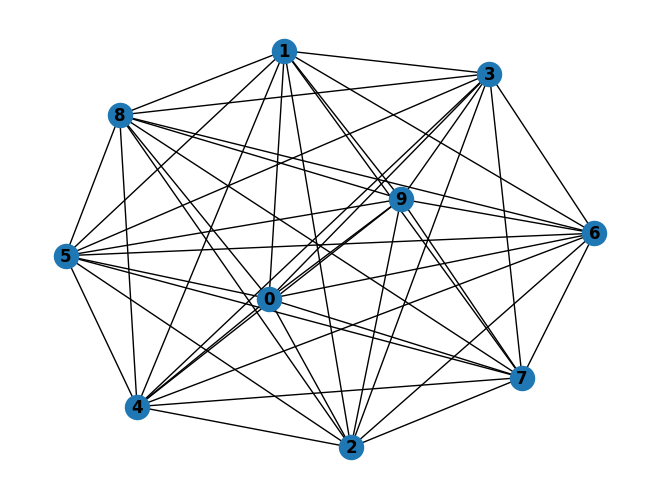

In [40]:
f1=0
f2=0
for k in range(3, 25):
    if(not sve(nx.complete_graph(k))):
        f1+=1
    if(not sve_c(nx.complete_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.complete_graph(10)
sve1(G)
sve1_c(G)

## Potpuni multipartitni graf

U teoriji grafova, k-partitni graf je graf čiji se čvorovi mogu podijeliti u k različitih nezavisnih skupova. Potpuni k-partitni graf je k-partitni graf u kojem postoji brid između svakog para čvorova iz različitih nezavisnih skupova.

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 196 grafova.
LC matrica: 
[[61 -8 -8 -7 -7 -7 -6 -6 -6 -6]
 [-8 61 -8 -7 -7 -7 -6 -6 -6 -6]
 [-8 -8 61 -7 -7 -7 -6 -6 -6 -6]
 [-7 -7 -7 59 -7 -7 -6 -6 -6 -6]
 [-7 -7 -7 -7 59 -7 -6 -6 -6 -6]
 [-7 -7 -7 -7 -7 59 -6 -6 -6 -6]
 [-6 -6 -6 -6 -6 -6 54 -6 -6 -6]
 [-6 -6 -6 -6 -6 -6 -6 54 -6 -6]
 [-6 -6 -6 -6 -6 -6 -6 -6 54 -6]
 [-6 -6 -6 -6 -6 -6 -6 -6 -6 54]]
Svojstvene vrijednosti: 
0.0 1
60.0 4
66.0 3
69.0 2
Svojstveni vektori: 
[[-0.3162 -0.2577  0.      0.005  -0.0156  0.0125  0.3605 -0.1912  0.2479
   0.778 ]
 [-0.3162 -0.2577  0.      0.005  -0.0156  0.0125  0.3605 -0.1912  0.5498
  -0.6037]
 [-0.3162 -0.2577 -0.      0.005  -0.0156  0.0125  0.3605 -0.1912 -0.7977
  -0.1743]
 [-0.3162 -0.2577  0.      0.005  -0.0156 -0.2996  0.0053  0.8623 -0.
   0.    ]
 [-0.3162 -0.2577  0.      0.005  -0.0156  0.7927 -0.4447  0.0849  0.
  -0.    ]
 [-0.3162 -0.2577 -0.      0.005  -0.0156 -0.5305 -0.6421 -0.3737

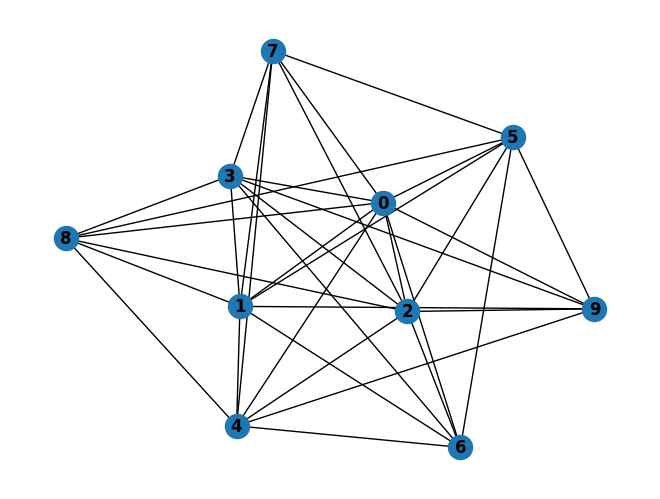

In [48]:
f1=0
f2=0
l=[]

for i in range(1, 10):
    for j in range(1, 10):
        li=[i, j]
        li.sort()
        if li not in l:
            if(not sve(nx.complete_multipartite_graph(i, j))):
                f1+=1
            if(not sve_c(nx.complete_multipartite_graph(i, j))):
                f2+=1
            l.append(li)

for i in range(1, 8):
    for j in range(1, 8):
        for k in range(1, 8):
            li=[i, j, k]
            li.sort()
            if li not in l:
                if(not sve(nx.complete_multipartite_graph(i, j, k))):
                    f1+=1
                if(not sve_c(nx.complete_multipartite_graph(i, j, k))):
                    f2+=1
                l.append(li)

for i in range(1, 6):
    for j in range(1, 6):
        for k in range(1, 6):
            for m in range(1, 6):
                li=[i, j, k, m]
                li.sort()
                if li not in l:
                    if(not sve(nx.complete_multipartite_graph(i, j, k, m))):
                        f1+=1
                    if(not sve_c(nx.complete_multipartite_graph(i, j, k, m))):
                        f2+=1
                    l.append(li)

if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} grafova.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} grafova.")

G = nx.complete_multipartite_graph(1, 2, 3, 4)
sve1(G)
sve1_c(G)

## Putni graf

Putni se graf sastoji od n linearno povezanih čvorova. Generira ga se funkcijom nx.path_graph(n).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 30 vrijednosti.
LC matrica: 
[[24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1]
 [-

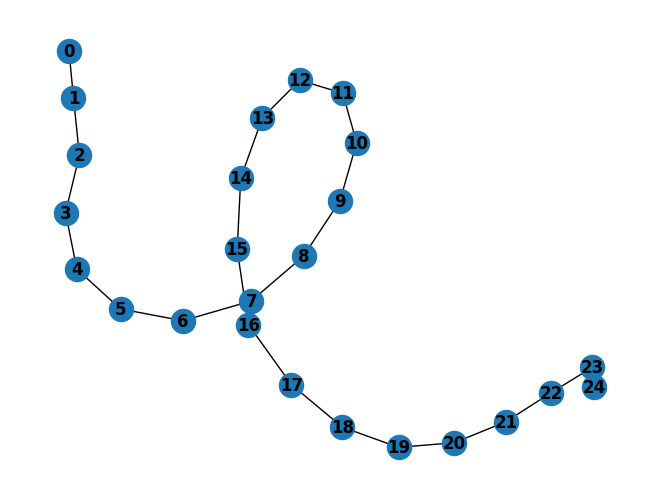

In [130]:
f1=0
f2=0
for k in range(3, 35):
    if(not sve(nx.path_graph(k))):
        f1+=1
    if(not sve_c(nx.path_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.path_graph(25)
sve1(G)
sve1_c(G)

## Ciklički graf

Ciklički je graf putni graf sa povezanim nultim i n-tim članom. Generira ga se funkcijom nx.cycle_graph(n).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 32 vrijednosti.
LC matrica: 
[[48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 -2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 48 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
  -2]
 [-

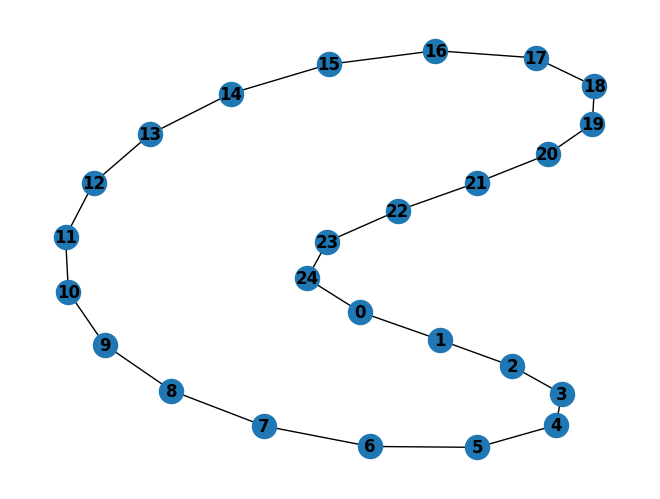

In [131]:
f1=0
f2=0
for k in range(3, 35):
    if(not sve(nx.cycle_graph(k))):
        f1+=1
    if(not sve_c(nx.cycle_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.cycle_graph(25)
sve1(G)
sve1_c(G)

## Ljestvasti graf

Ljestvasti se graf sastoji od dva puta s n čvorova, pri čemu je svaki par čvorova spojen jednim bridom. Generira ga se funkcijom nx.ladder_graph(n)

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 17 vrijednosti.
LC matrica: 
[[26 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
 [-2 27 -2 -2 -2 -2 -2 -2 -3 -2 -2 -2 -2 -2]
 [-2 -2 27 -2 -2 -2 -2 -2 -2 -3 -2 -2 -2 -2]
 [-2 -2 -2 27 -2 -2 -2 -2 -2 -2 -3 -2 -2 -2]
 [-2 -2 -2 -2 27 -2 -2 -2 -2 -2 -2 -3 -2 -2]
 [-2 -2 -2 -2 -2 27 -2 -2 -2 -2 -2 -2 -3 -2]
 [-2 -2 -2 -2 -2 -2 26 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -2 -2 -2 26 -2 -2 -2 -2 -2 -2]
 [-2 -3 -2 -2 -2 -2 -2 -2 27 -2 -2 -2 -2 -2]
 [-2 -2 -3 -2 -2 -2 -2 -2 -2 27 -2 -2 -2 -2]
 [-2 -2 -2 -3 -2 -2 -2 -2 -2 -2 27 -2 -2 -2]
 [-2 -2 -2 -2 -3 -2 -2 -2 -2 -2 -2 27 -2 -2]
 [-2 -2 -2 -2 -2 -3 -2 -2 -2 -2 -2 -2 27 -2]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 26]]
Svojstvene vrijednosti: 
0.0 1
28.0 8
30.0 5
Svojstveni vektori: 
[[-0.2673  0.      0.      0.      0.      0.9636  0.      0.      0.
   0.      0.      0.      0.      0.    ]
 [-0.2673  0.0997  0.0126  0.6013  0.0165 -0.0741 -0.1146 -0.1909 -0.0391

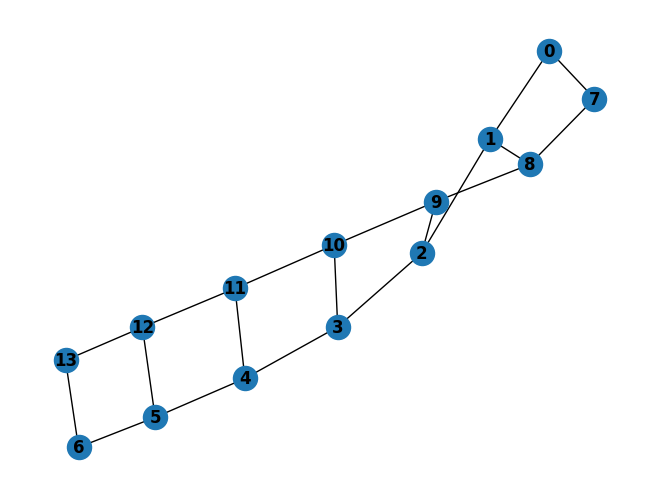

In [132]:
f1=0
f2=0
for k in range(3, 20):
    if(not sve(nx.ladder_graph(k))):
        f1+=1
    if(not sve_c(nx.ladder_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.ladder_graph(7)
sve1(G)
sve1_c(G)

## Kružni ljestvasti graf

Kružni ljestvasti graf sastoji se od dva ciklička grafa od  n čvorova, pri čemu je svaki par čvorova spojen jednim bridom. Generira ga se funkcijom nx.circular_ladder_graph(n)

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 17 vrijednosti.
LC matrica: 
[[39 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 39 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 39 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 39 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 39 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 39 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 39 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 39 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 39 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 39 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 39 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 39 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 39 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 39]]
Svojstvene vrijednosti: 
0.0 1
42.0 13
Svojstveni vektori: 
[[ 2.673e-01  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   9.636e-01  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 2.673e-01 -7.830e-02  7.963e

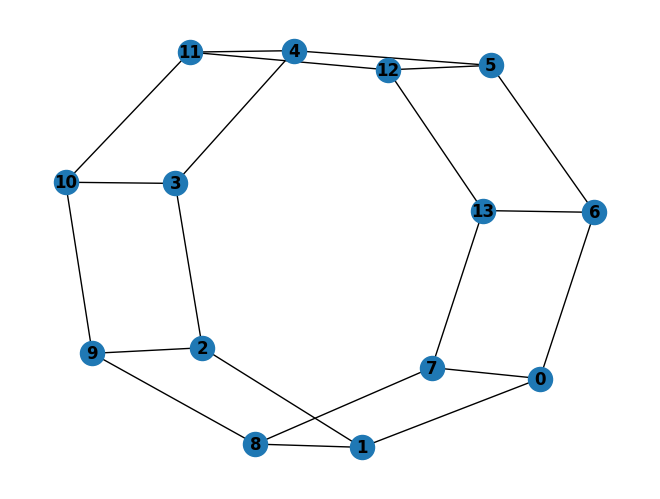

In [133]:
f1=0
f2=0
for k in range(3, 20):
    if(not sve(nx.circular_ladder_graph(k))):
        f1+=1
    if(not sve_c(nx.circular_ladder_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.circular_ladder_graph(7)
sve1(G)
sve1_c(G)

## Puno r-arno stablo

Puno r-arno stablo je vrsta stabla u kojemu svi ne-listovi imaju točno r djece i sve su razine pune osim nekih najdesnijih na najnižoj razini. Generira ga se funkcijom nx.full_rary_tree(r, n), gdje je n ukupni broj čvorova u grafu.

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 6 parova vrijednosti.
LC matrica: 
[[14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14]]
Svojstvene vrijednosti: 
-0.0 1
15.0 14
Svojstveni vektori: 
[[-0.2582 -0.3469  0.      0.      0.      0.      0.9017  0.      0.
   0.      0.      0.    

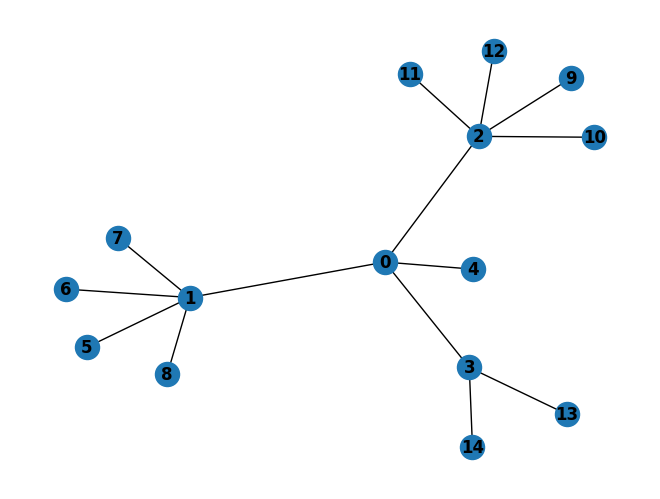

In [140]:
f1=0
f2=0
for r in range(2, 4):
    for n in range(1, 5):
        if(not sve(nx.balanced_tree(r, n))):
            f1+=1
        if(not sve_c(nx.balanced_tree(r, n))):
            f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} parova vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} parova vrijednosti.")

G=nx.full_rary_tree(4,15)
sve1(G)
sve1_c(G)

## Graf lizalice

Graf lizalice se sastoji od potpunog grafa od m čvorova povezanog na put od n čvorova. Generira ga se funkcijom nx.lollipop_graph(m, n).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 53 parova vrijednosti.
LC matrica: 
[[21 -4 -4 -4 -4 -1 -1 -1 -1 -1]
 [-4 21 -4 -4 -4 -1 -1 -1 -1 -1]
 [-4 -4 21 -4 -4 -1 -1 -1 -1 -1]
 [-4 -4 -4 21 -4 -1 -1 -1 -1 -1]
 [-4 -4 -4 -4 21 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  9 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  9 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  9 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1  9 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  9]]
Svojstvene vrijednosti: 
0.0 1
10.0 5
25.0 4
Svojstveni vektori: 
[[-0.3162  0.      0.      0.     -0.3162  0.      0.      0.      0.8944
   0.    ]
 [-0.3162  0.      0.      0.     -0.3162 -0.     -0.257  -0.6863 -0.2236
  -0.4614]
 [-0.3162  0.      0.     -0.     -0.3162  0.     -0.4804  0.0614 -0.2236
   0.718 ]
 [-0.3162 -0.      0.     -0.     -0.3162  0.     -0.0958  0.7186 -0.2236
  -0.4737]
 [-0.3162  0.     -0.      0.     -0.3162  0.      0.8331 -0.0937 -0.2236
   0.2172]
 [-0.3162 -0.4237 -0.1191 -0.7777  0.3162 -0.0392  0. 

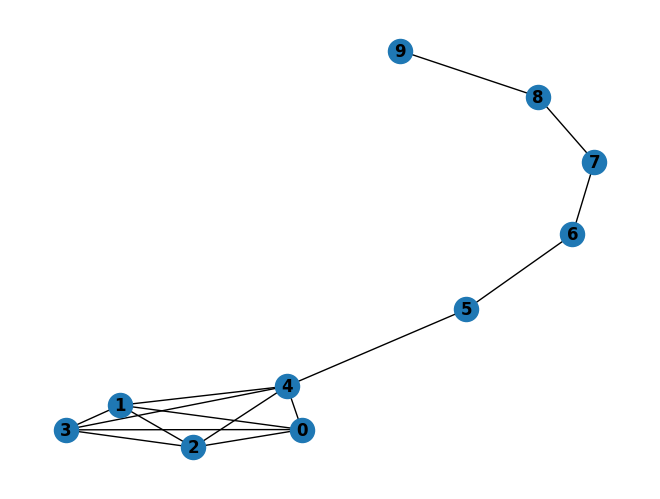

In [142]:
f1=0
f2=0
for m1 in range(2, 20):
    for m2 in range(2, 5):
        if(not sve(nx.lollipop_graph(m1, m2))):
            f1+=1
        if(not sve_c(nx.lollipop_graph(m1, m2))):
            f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} parova vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} parova vrijednosti.")

G = nx.lollipop_graph(5, 5)
sve1(G)
sve1_c(G)

## Zvjezdasti graf

Zvjezdasti graf čini jedan središnji čvor koji je povezan sa n vanjskih čvorova. Generira ga se funkcijom nx.star_graph(n).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 31 vrijednosti.
LC matrica: 
[[25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 

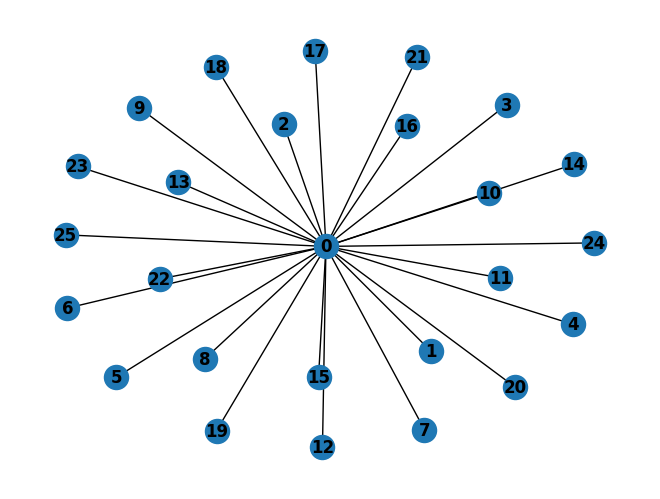

In [143]:
f1=0
f2=0
for k in range(3, 35):
    if(not sve(nx.star_graph(k))):
        f1+=1
    if(not sve_c(nx.star_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.star_graph(25)
sve1(G)
sve1_c(G)

## Graf kotača

Graf kotača sastoji se od središnjeg čvora povezanog na svaki čvor ciklusa od n-1 čvorova. Generira ga se funkcijom nx.wheel_graph(n).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 32 vrijednosti.
LC matrica: 
[[72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3 72 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3 -3
  -3]
 [-

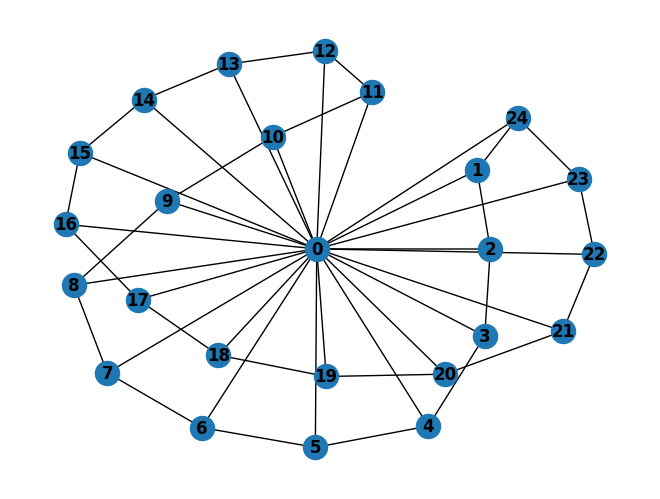

In [145]:
f1=0
f2=0
for k in range(3, 35):
    if(not sve(nx.wheel_graph(k))):
        f1+=1
    if(not sve_c(nx.wheel_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.wheel_graph(25)
sve1(G)
sve1_c(G)

## Trivijalni graf

Trivijalni se graf sadrži samo 1 čvor. Generira ga se funkcijom nx.trivial_graph().

LC matrica: 
[[0]]
Svojstvene vrijednosti: 
0.0 1
Svojstveni vektori: 
[[1.]]
Modificirana hipoteza vrijedi za dani graf.
Klasična hipoteza vrijedi za dani graf.


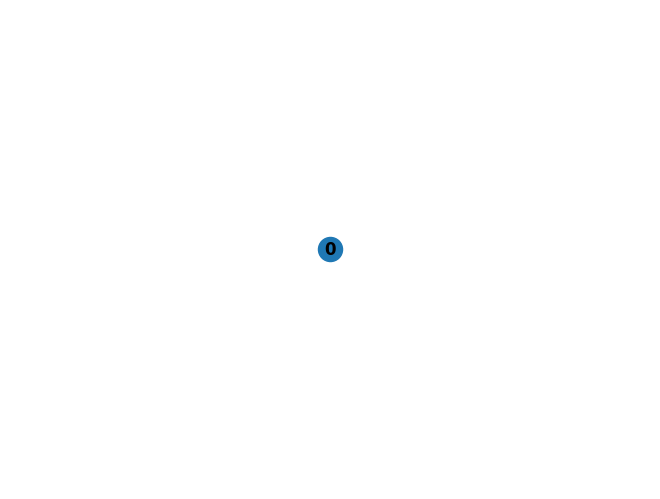

In [144]:
G = nx.trivial_graph()
sve1(G)
sve1_c(G)

## Hiperkocka graf

Hiperkocka graf $Q_n$ je graf formiran od vrhova i bridova n-dimenzionalne hiperkocke. $Q_n$ sadrži $2^n$ vrhova i $2^{n-1}n$ bridova te je regularan graf sa $n$ bridova koji dodiruju svaki vrh. Generira ga se funkcijom nx.hypercube_graph(n).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 5 vrijednosti.
LC matrica: 
[[21 -3 -3 -3 -3 -3 -3 -3]
 [-3 21 -3 -3 -3 -3 -3 -3]
 [-3 -3 21 -3 -3 -3 -3 -3]
 [-3 -3 -3 21 -3 -3 -3 -3]
 [-3 -3 -3 -3 21 -3 -3 -3]
 [-3 -3 -3 -3 -3 21 -3 -3]
 [-3 -3 -3 -3 -3 -3 21 -3]
 [-3 -3 -3 -3 -3 -3 -3 21]]
Svojstvene vrijednosti: 
0.0 1
24.0 7
Svojstveni vektori: 
[[-0.3536  0.      0.      0.      0.      0.      0.      0.9354]
 [-0.3536  0.8819 -0.252   0.126  -0.     -0.      0.     -0.1336]
 [-0.3536 -0.0914  0.5976  0.7012 -0.     -0.      0.     -0.1336]
 [-0.3536 -0.0914  0.0976 -0.2988 -0.1667 -0.1667 -0.8333 -0.1336]
 [-0.3536 -0.0914  0.0976 -0.2988 -0.5    -0.5     0.5    -0.1336]
 [-0.3536 -0.0914  0.0976 -0.2988  0.8333 -0.1667  0.1667 -0.1336]
 [-0.3536 -0.0914  0.0976 -0.2988 -0.1667  0.8333  0.1667 -0.1336]
 [-0.3536 -0.4248 -0.7358  0.3679 -0.     -0.      0.     -0.1336]]
Modificirana hipoteza vrijedi za dani graf.
Klasična hipoteza ne vrijed

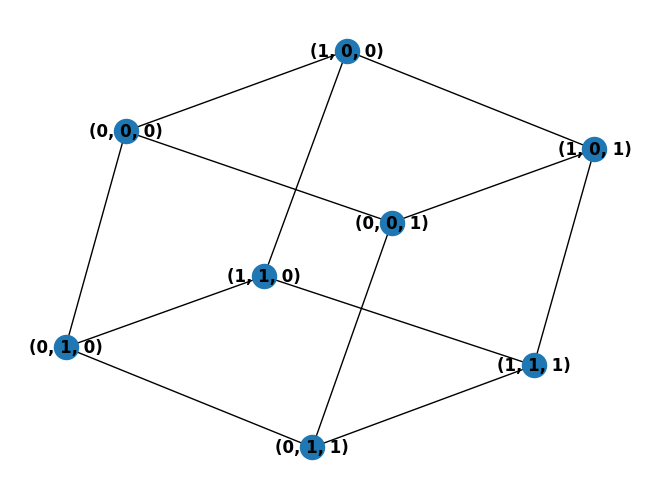

In [14]:
f1=0
f2=0
for k in range(1, 7):
    if(not sve(nx.hypercube_graph(k))):
        f1+=1
    if(not sve_c(nx.hypercube_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.hypercube_graph(3)
sve1(G)
sve1_c(G)

## Petersenov graf

Petersenov je graf neplanarni simetričmi graf sa 10 vrhova i 15 bridova. Generira ga se sa nx.petersen_graph()

LC matrica: 
[[27 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 27 -3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 27 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 27 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 27 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 27 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 27 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 27 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 27 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 27]]
Svojstvene vrijednosti: 
0.0 1
30.0 9
Svojstveni vektori: 
[[-0.3162  0.      0.9487  0.      0.      0.      0.      0.      0.
   0.    ]
 [-0.3162  0.5774 -0.1054  0.2023  0.0819 -0.3187 -0.3187 -0.3187 -0.3187
  -0.3187]
 [-0.3162 -0.433  -0.1054  0.8364 -0.0048  0.0188  0.0188  0.0188  0.0188
   0.0188]
 [-0.3162 -0.433  -0.1054 -0.3424 -0.6694 -0.165  -0.165  -0.165  -0.165
  -0.165 ]
 [-0.3162 -0.433  -0.1054 -0.3424  0.7356 -0.0928 -0.0928 -0.0928 -0.0928
  -0.0928]
 [-0.3162  0.1443 -0.1054 -0.0708 -0.0287  0.9116 -0.0884 -0.0884 -0.0884
  -0.0884]
 [-0.3162  0.1443 -0.1054 -0.0708 -0.0287 -0.0884  0.9116 -0.0884 -0.0884
  -0.0884]
 [-0.31

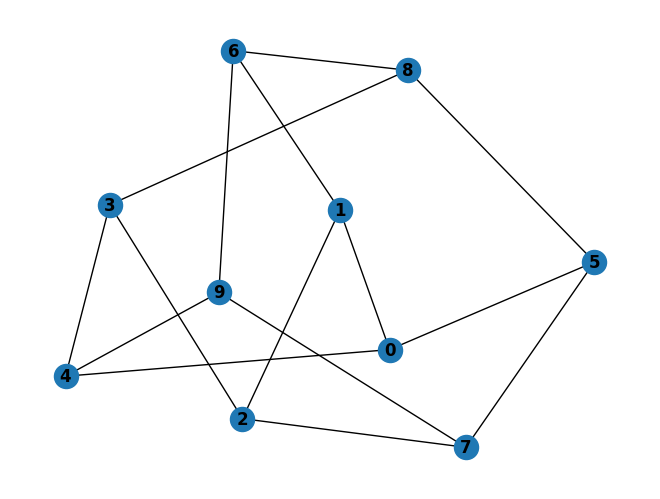

In [25]:
G = nx.petersen_graph()
sve1(G)
sve1_c(G)

## Mycielski graf

Kromatski broj k grafa G je najmanji broj boja potrebnih za obojiti vrhove grafa tako da nikoja dva susjedna vrha nisu obojena istom bojom. Mycielski graf reda k je graf kromatskog broja k koji ima minimalan broj vrhova sa uvjetom da ne sadrži kliku od tri vrha. Generira ga se funkcijom nx.mycielski_graph(k).

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 4 vrijednosti.
LC matrica: 
[[35 -4 -4 -4 -4 -3 -3 -3 -3 -3 -4]
 [-4 35 -4 -4 -4 -3 -3 -3 -3 -3 -4]
 [-4 -4 35 -4 -4 -3 -3 -3 -3 -3 -4]
 [-4 -4 -4 35 -4 -3 -3 -3 -3 -3 -4]
 [-4 -4 -4 -4 35 -3 -3 -3 -3 -3 -4]
 [-3 -3 -3 -3 -3 30 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 30 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 30 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 30 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 30 -3]
 [-4 -4 -4 -4 -4 -3 -3 -3 -3 -3 35]]
Svojstvene vrijednosti: 
-0.0 1
33.0 5
39.0 5
Svojstveni vektori: 
[[-0.3015  0.      0.      0.     -0.2752  0.      0.      0.9129  0.
   0.      0.    ]
 [-0.3015 -0.     -0.      0.     -0.2752  0.      0.7815 -0.1826 -0.3659
  -0.1814 -0.15  ]
 [-0.3015 -0.     -0.      0.     -0.2752  0.     -0.5219 -0.1826 -0.1906
  -0.2083 -0.6692]
 [-0.3015 -0.      0.      0.     -0.2752 -0.     -0.3279 -0.1826 -0.3301
  -0.243   0.7242]
 [-0.3015  0.      0.     -0.     -0.2752  0.      0

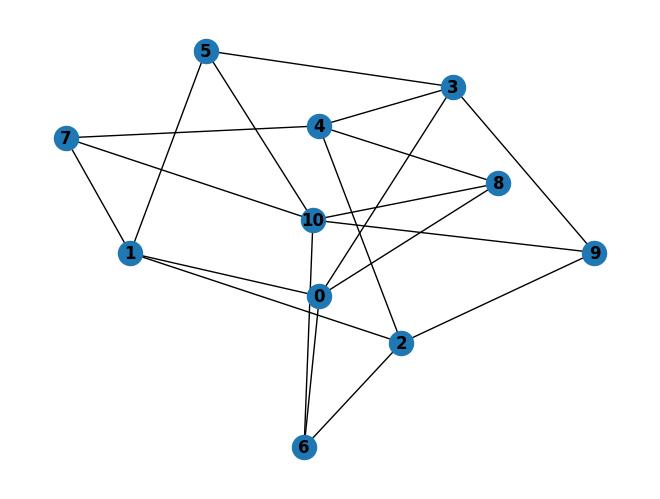

In [ ]:
f1=0
f2=0
for k in range(1, 7):
    if(not sve(nx.mycielski_graph(k))):
        f1+=1
    if(not sve_c(nx.mycielski_graph(k))):
        f2+=1
if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} vrijednosti.")

G = nx.mycielski_graph(4)
sve1(G)
sve1_c(G)

## Mrežni graf

U mrežnom su grafu čvorovi raspoređeni u pravokutnu mrežu te bridovima povezani sa susjednim čvorovima(ispred-iza, lijevo-desno, gore-dolje). N-dimenzionalni se mrežni graf generira funkcijom nx.grid_graph(dim), gdje je dim lista/uređena n-torka dimenzija.

Modificirana hipoteza vrijedi za sve testirane grafove.
Klasična hipoteza ne vrijedi za 16 trojki vrijednosti.
LC matrica: 
[[ 78  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3  -3  -3  -3  -3  -3]
 [ -3  96  -3  -4  -4  -4  -3  -4  -3  -4  -4  -4  -4  -4  -4  -4  -4  -4
   -3  -4  -3  -4  -4  -4  -3  -4  -3]
 [ -3  -3  78  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3  -3  -3  -3  -3  -3]
 [ -3  -4  -3  96  -4  -4  -3  -4  -3  -4  -4  -4  -4  -4  -4  -4  -4  -4
   -3  -4  -3  -4  -4  -4  -3  -4  -3]
 [ -3  -4  -3  -4 102  -4  -3  -4  -3  -4  -5  -4  -5  -5  -5  -4  -5  -4
   -3  -4  -3  -4  -5  -4  -3  -4  -3]
 [ -3  -4  -3  -4  -4  96  -3  -4  -3  -4  -4  -4  -4  -4  -4  -4  -4  -4
   -3  -4  -3  -4  -4  -4  -3  -4  -3]
 [ -3  -3  -3  -3  -3  -3  78  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3
   -3  -3  -3  -3  -3  -3  -3  -3  -3]
 [ -3  -4  -3  -4  -4  -4  -3  96  -3  -4  -4  -4  -4  -4  -4  -4  -4  -4
   -3  -4  

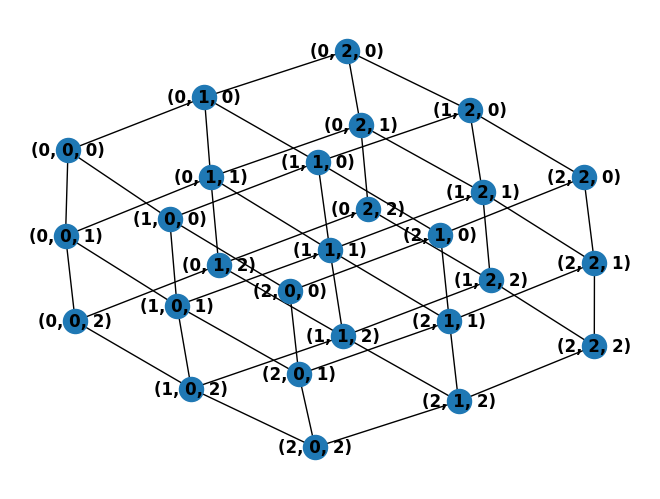

In [38]:
# Trodimenzionalni mrežni graf dimenzije n1 x n2 x 1 ekvivalentan je dvodimenzionalnom mrežnom grafu dimenzije n1 x n2.
# Mrežni graf dimenzije n1 x n2 ekvivalentan je mrežnom grafu dimenzije n2 x n1.

f1=0
f2=0
l=[]

for i in range(1, 5):
    for j in range(1, 5):
        for k in range(1, 5):
            li=[i, j, k]
            li.sort()
            if li not in l:
                if(not sve(nx.grid_graph(li))):
                    f1+=1
                if(not sve_c(nx.grid_graph(li))):
                    f2+=1
                l.append(li)

if f1 == 0:
    print("Modificirana hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Modificirana hipoteza ne vrijedi za {f1} trojki vrijednosti.")
if f2 == 0:
    print("Klasična hipoteza vrijedi za sve testirane grafove.")
else:
    print(f"Klasična hipoteza ne vrijedi za {f2} trojki vrijednosti.")

G = nx.grid_graph([3, 3, 3])
sve1(G)
sve1_c(G)